In [ ]:
!pip install grad-cam
!pip install timm

import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.transforms as transforms
from torchvision import models

from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

from skimage.feature import peak_local_max

import timm


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
file_name_25_img = 'imagenet_val_25.npz'
if not os.path.exists(file_name_25_img):
    !wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-b/imagenet_val_25.npz

f = np.load("imagenet_val_25.npz", allow_pickle=True)
X, y, class_names = f["X"], f["y"], f["label_map"].item()
class_names_to_id = {name: id for id, name in class_names.items()}

y_long = torch.tensor(y, dtype=torch.long)
one_hot_y = F.one_hot(y_long, num_classes = 1000)
one_hot_y = one_hot_y.float()

plt.figure(figsize=(15, 7))
for i in range(24):
    plt.subplot(4, 6, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()


In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def resize_img(model_name, img):
    """
    Resize and normalize a batch of images according to the requirements of a specified model
    using OpenCV for image resizing.

    Parameters:
    - model_name (str): The name of the model ('squeezenet', 'resnet50', 'inceptionv4').
    - img (numpy.ndarray): A batch of images (batch size, height, width, channels).

    Returns:
    - numpy.ndarray: A batch of resized and normalized images.
    """

    # Define the target size for each model
    model_sizes = {
        "squeezenet": 224,
        "resnet50": 224,
        "inceptionv4": 299
    }

    # Check if the model is supported
    if model_name not in model_sizes:
        raise ValueError(f"Model not supported: {model_name}")

    # Get the target size for the specified model
    target_size = model_sizes[model_name]

    # Initialize the array for resized images
    img_resized = np.zeros((len(img), target_size, target_size, 3), dtype=np.float32)

    # Resize and normalize images
    for i, image in enumerate(img):
        # Resize image using OpenCV. OpenCV expects the size in (width, height) format.
        image_resized = cv2.resize(image, (target_size, target_size), interpolation=cv2.INTER_LANCZOS4)
        # Normalize the resized image
        img_resized[i] = image_resized / 255.0

    return img_resized

class Preprocessing_Transform:
    def __init__(self, mean, std, model_name):
        self.mean = mean
        self.std = std
        self.model_name = model_name

    def __call__(self, img):
        img = resize_img(self.model_name, img)
        img_normalized = (img - np.array(self.mean)[None, None, None, :]) / np.array(self.std)[None, None, None, :] # Normalize
        return torch.tensor(img_normalized, dtype=torch.float32).permute(0, 3, 1, 2)

class NumpyDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

preprocess_squeezenet = transforms.Compose([
    Preprocessing_Transform(mean, std, "squeezenet")
])

preprocess_inceptionv4 = transforms.Compose([
    Preprocessing_Transform(mean, std, "inceptionv4")
])

preprocess_resnet50 = transforms.Compose([
    Preprocessing_Transform(mean, std, "resnet50")
])

unpreprocessed_dataset = NumpyDataset(X)
dataset_resnet50 = preprocess_resnet50(unpreprocessed_dataset)
dataset_squeezenet = preprocess_squeezenet(unpreprocessed_dataset)
dataset_inceptionv4 = preprocess_inceptionv4(unpreprocessed_dataset)

In [ ]:
class Depreprocessing_Transform:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, img_normalized):
        img_denormalized = (img_normalized.permute(0, 2, 3, 1) * torch.tensor(self.std)[None, None, None, :]) + torch.tensor(self.mean)[None, None, None, :]
        return img_denormalized

depreprocess = Depreprocessing_Transform(mean, std)

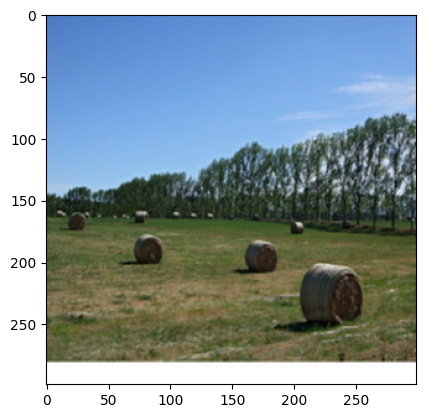

In [ ]:
plt.imshow(depreprocess(dataset_inceptionv4[0].unsqueeze(0)).squeeze())

In [ ]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # activate gradients on X
    model.eval()
    X.requires_grad = True
    N, _, H, W = X.shape
    yhat = model(X)

    if X.grad is not None:  # Is it necessary ?
        X.grad.zero_()

    # Select yhat_i for each row
    yhat_i = yhat[np.arange(N), y]

    # Backward
    yhat_i.backward(torch.ones_like(yhat_i))
    saliency, _ = torch.max(X.grad.data.abs(), dim=1)

    return saliency

In [ ]:
# Load the model
resnet50_model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
resnet50_model.to(device)

# Freeze the weights
for param in resnet50_model.parameters():
    param.requires_grad = False

# Model in test mode
resnet50_model.eval()

# Load the model
squeezenet_model = torchvision.models.squeezenet1_1(weights=torchvision.models.SqueezeNet1_1_Weights.DEFAULT)
squeezenet_model.to(device)

# Freeze the weights
for param in squeezenet_model.parameters():
    param.requires_grad = False

# Model in test mode
squeezenet_model.eval()

inceptionv4_model = timm.create_model('inception_v4', pretrained=True)
inceptionv4_model.to(device)

# Freeze the weights
for param in inceptionv4_model.parameters():
    param.requires_grad = False

# Model in test mode
inceptionv4_model.eval()

In [ ]:
# Organize in dictionnary
models = {"resnet50": resnet50_model,
          "squeezenet": squeezenet_model,
          "inceptionv4": inceptionv4_model}

# Set target layers
target_layers = {"resnet50": resnet50_model.layer4[-1],
                 "squeezenet": squeezenet_model.features[-1],
                 "inceptionv4": inceptionv4_model.features[-1]}

In [ ]:
targets = [ClassifierOutputTarget(class_id) for class_id in y]

input_tensor_squeezenet = torch.clone(dataset_squeezenet).detach().requires_grad_(True)

# Construct the CAM object once, and then re-use it on many images:
cam_squeezenet = GradCAM(model=squeezenet_model, target_layers=[target_layers["squeezenet"]])

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam_squeezenet = cam_squeezenet(input_tensor=input_tensor_squeezenet, targets=targets)

input_tensor_inceptionv4 = torch.clone(dataset_inceptionv4).detach().requires_grad_(True)

# Construct the CAM object once, and then re-use it on many images:
cam_inceptionv4 = GradCAM(model=inceptionv4_model, target_layers=[target_layers["inceptionv4"]])

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam_inceptionv4 = cam_inceptionv4(input_tensor=input_tensor_inceptionv4, targets=targets)

input_tensor_resnet50 = torch.clone(dataset_resnet50).detach().requires_grad_(True)

# Construct the CAM object once, and then re-use it on many images:
cam_resnet50 = GradCAM(model=resnet50_model, target_layers=[target_layers["resnet50"]])

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam_resnet50 = cam_resnet50(input_tensor=input_tensor_resnet50, targets=targets)

In [ ]:
def print_cams(grayscale_cams, model_name, X):

  resized_X = resize_img(model_name, X)

  grayscale_cams = [cam.squeeze() for cam in grayscale_cams]  # Removing any extra dimensions

  num_images_to_display = 25

  columns = 5  # Number of columns in the grid
  rows = math.ceil(num_images_to_display / columns)  # Calculate the number of rows needed

  fig, axes = plt.subplots(rows, columns, figsize=(15, rows * 3))  # Adjust figsize as needed
  axes = axes.flatten()  # Flatten the axes array for easy indexing

  for i in range(num_images_to_display):
      if i < len(X):

          img = resized_X[i]

          # Get the corresponding CAM
          cam_image = grayscale_cams[i]

          # Overlay CAM on the image
          visualization = show_cam_on_image(img, cam_image, use_rgb=True)

          ax = axes[i]
          ax.imshow(visualization)
          ax.axis('off')
      else:
          break  # Break if there are no more images

  # Hide any unused axes if there are fewer images than subplots
  for ax in axes[num_images_to_display:]:
      ax.axis('off')

  plt.show()

In [ ]:
print_cams(grayscale_cam_squeezenet, "squeezenet", X)

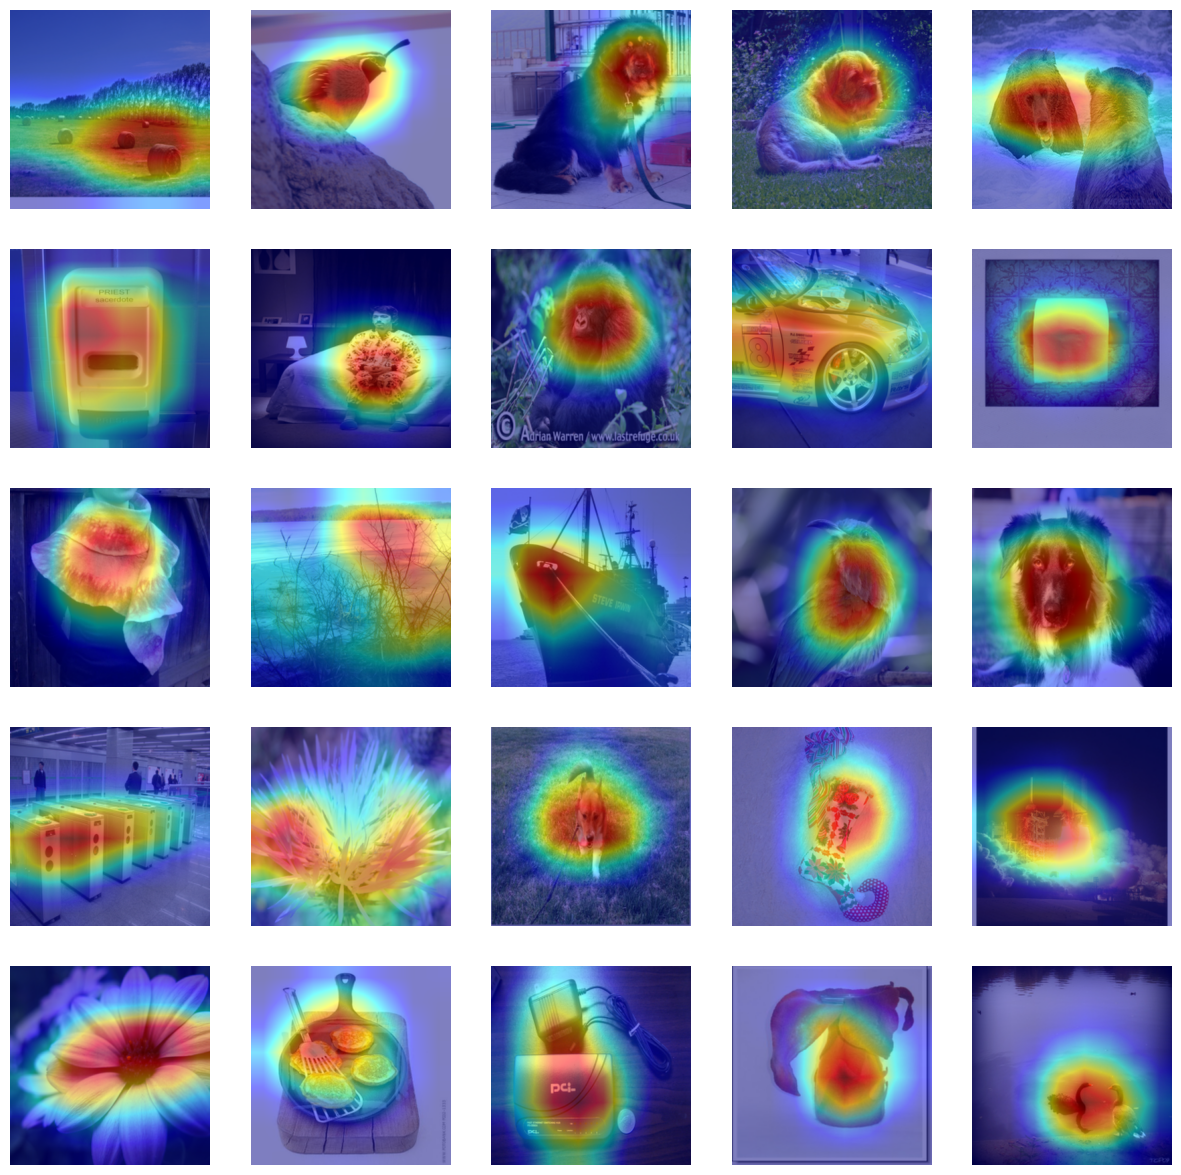

In [ ]:
print_cams(grayscale_cam_inceptionv4, "inceptionv4", X)

In [ ]:
print_cams(grayscale_cam_resnet50, "resnet50", X)

**Implementation avec inception_v4**

In [ ]:
#with torch.no_grad():
#    out = model(torch.Tensor(X[0]).permute(2,0,1).unsqueeze(0))
#probabilities = torch.nn.functional.softmax(out[0], dim=0)
#print(probabilities.shape)

In [ ]:
def get_centers(M, ratio_threshold = 0.6, min_distance = 20):
    # Find coordinates of local maxima
    coordinates = peak_local_max(M, num_peaks=3, exclude_border=False, min_distance=min_distance)

    if len(coordinates)==0:
      global_max_index = np.unravel_index(np.argmax(M), M.shape)
      return np.array([global_max_index])

    # Extract the values at these coordinates
    maxima_values = M[coordinates[:, 0], coordinates[:, 1]]

    # Determine the highest value among the maxima
    highest_maxima_value = max(maxima_values)

    # Filter coordinates based on the threshold
    filtered_coordinates = coordinates[maxima_values >= ratio_threshold * highest_maxima_value]
    return filtered_coordinates

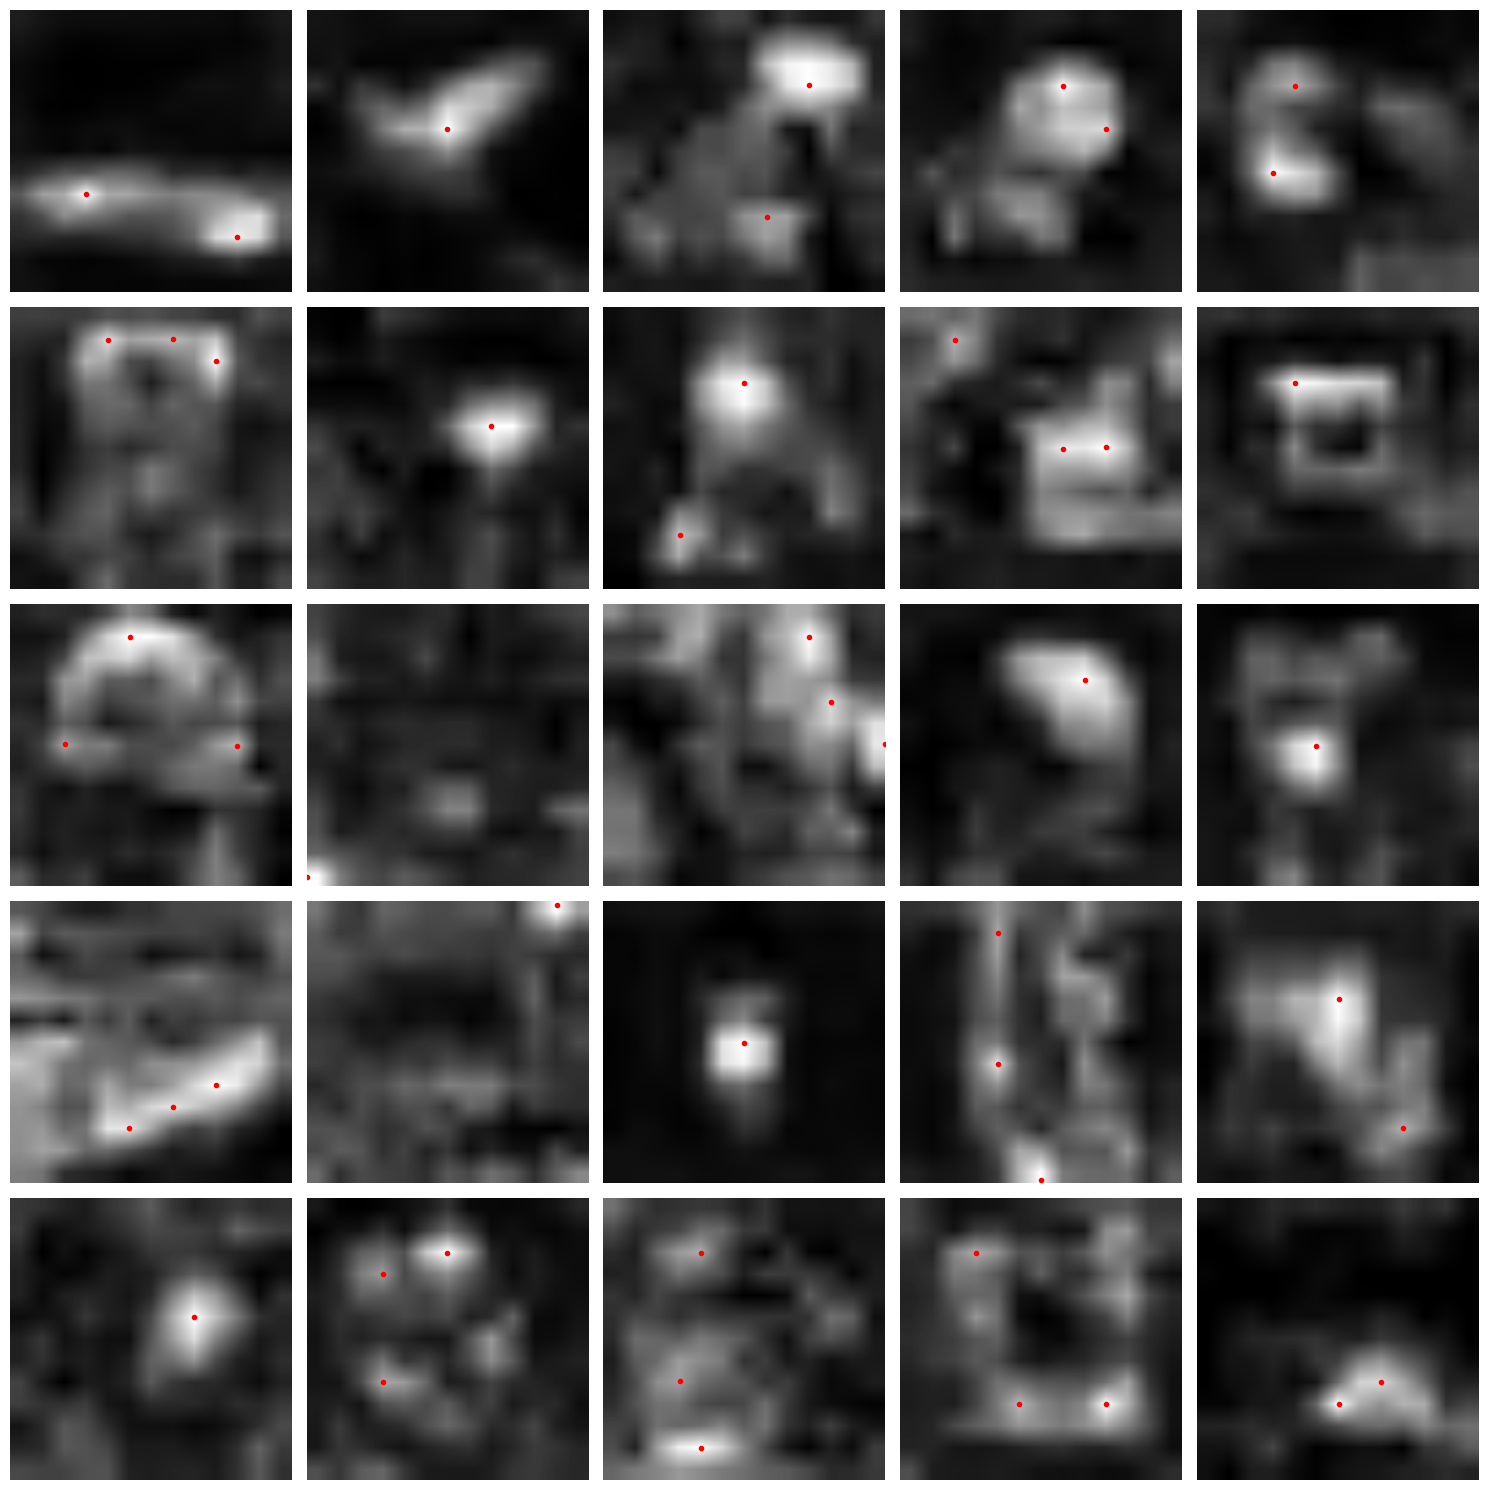

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

for i, ax in enumerate(axes):
    M = grayscale_cam_squeezenet[i]

    # Plot the grayscale cam
    ax.imshow(M, cmap='gray')

    filtered_coordinates = get_centers(M, ratio_threshold = 0.6, min_distance = 20)

    # Plot the filtered coordinates on the images
    ax.plot(filtered_coordinates[:, 1], filtered_coordinates[:, 0], 'r.')
    ax.set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
def ADP(x_clean, y_true, model_name, ratio_threshold, min_distance, eps, T, alpha, beta, m):
  #y_true = np.argmax(torch.nn.functional.softmax(model(x_clean)[0], dim=0))

  model = models[model_name]

  target_layer = [target_layers[model_name]]
  cam = GradCAM(model=model, target_layers=target_layer)

  targets = [ClassifierOutputTarget(np.argmax(y_true))]

  x_adv = torch.clone(x_clean).detach().requires_grad_(True)

  W, H = x_clean.shape[1], x_clean.shape[2]

  criterion = torch.nn.CrossEntropyLoss()

  for t in range(0, T):
    x_adv.requires_grad_(True)
    g=0
    M = cam(input_tensor=x_adv, targets=targets)

    centers = get_centers(M[0], ratio_threshold, min_distance)

    for center in centers:

      for k in range(1, m+1):
        x1 = int(max(center[0]-beta*k, 0))
        x2 = int(min(center[0]+beta*k, W))
        y1 = int(max(center[1]-beta*k, 0))
        y2 = int(min(center[1]+beta*k, H))

        x_drop = torch.clone(x_adv).detach()
        x_drop[:, x1:x2, y1:y2] = x_clean[:, x1:x2, y1:y2]
        x_drop = x_drop.detach()
        x_drop.requires_grad_(True)

        loss = criterion(model(x_drop)[0], y_true)
        loss.backward()

        grad = x_drop.grad.data
        g += grad

        x_drop.grad.zero_()

    g *= 1/(len(centers)*m)

    x_adv_max = x_adv + eps
    x_adv_min = x_adv - eps

    with torch.no_grad():

      g_sign = g.sign()
      perturbed_x_adv = x_adv + alpha * g_sign

      x_adv = torch.max(torch.min(perturbed_x_adv, x_adv_max), x_adv_min)

  return x_adv

In [ ]:
x_clean = dataset_inceptionv4[0].unsqueeze(0)
y_true = one_hot_y[0]

x_adv = ADP(x_clean, y_true, "inceptionv4", ratio_threshold=0.6, min_distance=20, eps=0.1, T=10, alpha=0.05, beta=15, m=5)
plt.imshow(depreprocess(x_adv).squeeze().detach())

In [ ]:
np.argmax(torch.nn.functional.softmax(models["inceptionv4"](x_adv)[0], dim=0)) == np.argmax(one_hot_y[0])

tensor(False)